# Examine the Null Forest S@S98 Distribution from Permutation and Coleman

In [24]:
import os
import sys
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sktree import HonestForestClassifier
from sktree.datasets import make_trunk_classification
from sktree.stats import (
    PermutationForestClassifier,
    PermutationHonestForestClassifier,
    build_coleman_forest,
)
from sktree.stats.utils import _compute_null_distribution_coleman

In [2]:
seed = 12345
rng = np.random.default_rng(seed)

# hard-coded parameters
n_estimators = 500
n_estimators_coleman = 6_000
max_features = 0.3
test_size = 0.2

# TODO: depends on how many CPUs are assigned per job
n_jobs = -2
n_jobs_trees = 1

n_repeats = 10_000


might_kwargs = {
    "n_estimators": n_estimators,
    "random_state": None,
    "honest_fraction": 0.5,
    "n_jobs": n_jobs_trees,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "permute_per_tree": False,
}

COLEMAN_MODELS = {
    "permute_once": {
        "n_estimators": n_estimators_coleman,
        "random_state": None,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": False,
    },
    "permute_per_tree": {
        "n_estimators": n_estimators_coleman,
        "random_state": None,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": True,
    },
}

In [3]:
def sensitivity_at_specificity(y_true, y_score, target_specificity=0.98, pos_label=1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score_binary, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = np.argmax(fpr >= (1 - target_specificity))
    threshold_at_specificity = thresholds[index]

    # Compute sensitivity at the chosen specificity
    # sensitivity = tpr[index]
    # return sensitivity

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity


def _run_parallel_might_permutations_chenchen(
    idx,
    n_samples,
    n_features,
    sim_type,
    rootdir,
):
    """Run parallel MIGHT on permuted and original pre-generated data.

    Generates two test statistics:
    - one on the observed data
    - one on the permuted data

    Parameters
    ----------
    idx : int
        The index of the pre-generated dataset, stored as npz file.
        Also used as the random seed where applicable.
    n_samples : int
        The number of samples to keep.
    n_features : int
        The number of dimensions to keep in feature set.
    sim_type : str
        The simulation type. Either 'independent', 'collider', 'confounder',
        or 'direct-indirect'.
    rootdir : str
        The root directory where 'data/' and 'output/' will be.
    """
    model_name = "permutation-test"

    # load data
    if sim_type == "trunk-overlap":
        X, y, mu, cov = make_trunk_classification(
            n_samples=n_samples,
            n_dim=n_dims,
            n_informative=min(256, n_dims),
            m_factor=1,
            return_params=True,
            seed=idx,
        )
    elif sim_type == "trunk":
        X, y, mu, cov = make_trunk_classification(
            n_samples=n_samples,
            n_dim=n_dims,
            n_informative=min(256, n_dims),
            m_factor=0.5,
            return_params=True,
            seed=idx,
        )
    X = np.float32(X)
    y = np.float32(y).reshape(-1, 1)

    print(
        f"Evaluating {model_name} on {sim_type} with {n_samples} samples and {n_features} features"
    )

    # set output directory to save npz files
    output_dir = os.path.join(rootdir, f"output/{model_name}/{sim_type}/")
    os.makedirs(output_dir, exist_ok=True)

    # now compute the pvalue when shuffling all
    covariate_index = np.arange(n_features, dtype=int)

    # Get drawn indices along both sample and feature axes
    indices = np.arange(n_samples, dtype=int)

    # Create a shuffled version of the dataset
    indices = indices.reshape(-1, 1)
    rng = np.random.default_rng(idx)
    rng.shuffle(indices)
    X_perm = X.copy()
    perm_X_cov = X_perm[indices, covariate_index]
    X_perm[:, covariate_index] = perm_X_cov

    permute_per_tree = might_kwargs.pop("permute_per_tree", False)
    est = HonestForestClassifier(**might_kwargs)

    # compute test statistic
    est.fit(X, y.ravel())
    y_score = est.predict_proba_per_tree(X, est.oob_samples_)
    observe_test_stat = sensitivity_at_specificity(
        y, y_score, target_specificity=0.98, pos_label=1
    )

    # train a new forest on the permuted data
    est.fit(X_perm, y.ravel())
    y_score = est.predict_proba_per_tree(X_perm, est.oob_samples_)

    # compute two instances of the metric from the sampled trees
    metric_val = sensitivity_at_specificity(
        y, y_score, target_specificity=0.98, pos_label=1
    )

    np.savez(
        os.path.join(
            output_dir, f"might_{sim_type}_{n_samples}_{n_features}_{idx}.npz"
        ),
        n_samples=n_samples,
        n_features=n_features,
        y_true=y,
        might_permute_stat=metric_val,
        might_stat=observe_test_stat,
    )


def _run_parallel_might(idx, n_samples, n_features, sim_type, rootdir, overwrite=False):
    """Run parallel job on pre-generated data.

    Runs two forests and generates a PValue using the Coleman method and its variations.

    Parameters
    ----------
    idx : int
        The index of the pre-generated dataset, stored as npz file.
        Also used as the random seed where applicable.
    n_samples : int
        The number of samples to keep.
    n_features : int
        The number of dimensions to keep in feature set.
    sim_type : str
        The simulation type. Either 'independent', 'collider', 'confounder',
        or 'direct-indirect'.
    rootdir : str
        The root directory where 'data/' and 'output/' will be.
    output_dir : str
        The directory under ``rootdir`` to store output.
    """
    # load data
    if sim_type == "trunk-overlap":
        X, y, mu, cov = make_trunk_classification(
            n_samples=n_samples,
            n_dim=n_dims,
            n_informative=min(256, n_dims),
            m_factor=1,
            return_params=True,
            seed=idx,
        )
    elif sim_type == "trunk":
        X, y, mu, cov = make_trunk_classification(
            n_samples=n_samples,
            n_dim=n_dims,
            n_informative=min(256, n_dims),
            m_factor=0.5,
            return_params=True,
            seed=idx,
        )
    X = np.float32(X)
    y = np.float32(y).reshape(-1, 1)

    for model_name in COLEMAN_MODELS:
        print(f"Evaluating {model_name} on {sim_type} with {n_samples} samples")

        # set output directory to save npz files
        output_dir = os.path.join(rootdir, f"output/{model_name}/{sim_type}/")
        os.makedirs(output_dir, exist_ok=True)
        output_fname = os.path.join(
            output_dir, f"might_{sim_type}_{n_samples}_{n_features}_{idx}.npz"
        )
        if not overwrite and os.path.exists(output_fname):
            continue

        # now compute the pvalue when shuffling all
        covariate_index = None

        permute_per_tree = might_kwargs.pop("permute_per_tree", False)

        est = HonestForestClassifier(**might_kwargs)
        perm_est = PermutationHonestForestClassifier(
            permute_per_tree=permute_per_tree, **might_kwargs
        )

        # compute pvalue
        (
            observe_test_stat,
            pvalue,
            orig_forest_proba,
            perm_forest_proba,
        ) = build_coleman_forest(
            est,
            perm_est,
            X,
            y,
            covariate_index=covariate_index,
            metric="s@98",
            n_repeats=n_repeats,
            seed=None,
            return_posteriors=True,
        )

        np.savez(
            output_fname,
            n_samples=n_samples,
            n_features=n_features,
            y_true=y,
            might_pvalue=pvalue,
            might_stat=observe_test_stat,
            might_posteriors=orig_forest_proba,
            might_null_posteriors=perm_forest_proba,
        )

In [5]:
SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/m_factor=-1/"

In [66]:
model_name = "permute_per_tree_4x10kreps"
model_name = "permutation-test_500"
sim_name = "trunk-05"
sim_type = "trunk"
n_samples = 1024
n_dims = 4096
idx = 2

file_name = (
    Path(SAVE_PATH)
    / model_name
    / sim_name
    / f"might_{sim_type}_{n_samples}_{n_dims}_{idx}.npz"
)
if not file_name.exists():
    print(f"Didn't find {file_name}")

data = np.load(file_name)
print(dict(data).keys())

# null posteriors
observe_stat = data["might_stat"]
permute_stat = data["might_permute_stat"]
print(observe_stat, permute_stat)

dict_keys(['n_samples', 'n_features', 'y_true', 'might_permute_stat', 'might_stat'])
0.02734375 0.0234375


In [64]:
model_name = "permute_per_tree_4x10kreps"
# model_name = "permutation-test_500"
sim_name = "trunk-05"
sim_type = "trunk"
n_samples = 1024
n_dims = 4096
idx = 2

file_name = (
    Path(SAVE_PATH)
    / model_name
    / sim_name
    / f"might_{sim_type}_{n_samples}_{n_dims}_{idx}.npz"
)
if not file_name.exists():
    print(f"Didn't find {file_name}")

data = np.load(file_name)
print(dict(data).keys())

# null posteriors
observe_stat = data["might_stat"]

might_null_posteriors = data["might_null_posteriors"]
might_posteriors = data["might_posteriors"]
y_true = data["y_true"]
print(might_null_posteriors.shape)

dict_keys(['n_samples', 'n_features', 'y_true', 'might_pvalue', 'might_stat', 'might_posteriors', 'might_null_posteriors'])
(1500, 1024, 2)


In [65]:
# y_pred_proba_perm = np.nanmean(might_null_posteriors, axis=0)

# observe_stat = sensitivity_at_specificity(y_true, y_pred_proba_orig)
permute_stat = sensitivity_at_specificity(y_true, might_null_posteriors)
print(sensitivity_at_specificity(y_true, might_posteriors) - permute_stat)
print(observe_stat, permute_stat)

-0.00390625
0.00390625 0.013671875


In [ ]:
metric_star, metric_star_pi = _compute_null_distribution_coleman(
    y_true,
    might_posteriors,
    might_null_posteriors,
    "s@98",
    n_repeats=5000,
    seed=idx,
)

In [ ]:
print("done")

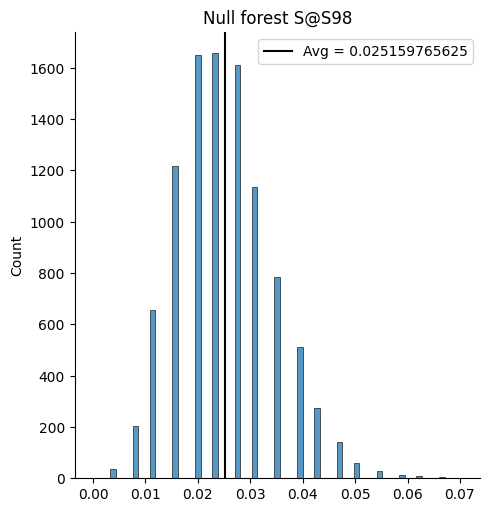

In [63]:
sns.displot(metric_star_pi)
plt.axvline(
    [np.mean(metric_star_pi).squeeze()],
    color="black",
    label=f"Avg = {np.mean(metric_star_pi)}",
)
plt.title("Null forest S@S98")
plt.legend()
plt.show()

Average of the alternative:  0.024251953125


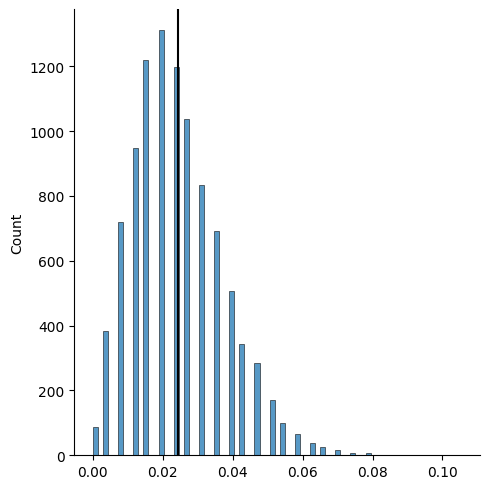

In [51]:
sns.displot(metric_star)
plt.axvline(np.mean(metric_star), color="black")
print("Average of the alternative: ", np.mean(metric_star))

Average of the null:  0.0009078125


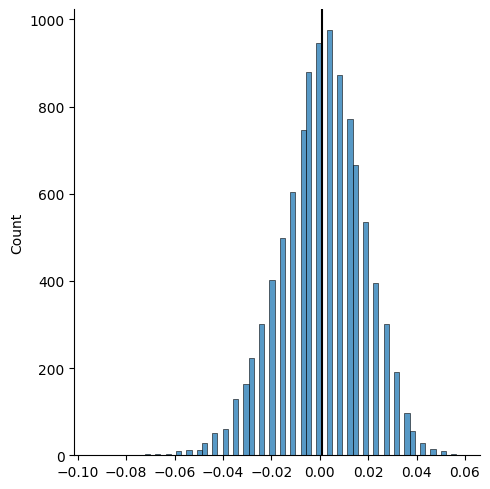

In [55]:
sns.displot(metric_star_pi - metric_star)
plt.axvline(np.mean(metric_star_pi - metric_star), color="black")
print("Average of the null: ", np.mean(metric_star_pi - metric_star))